# Setup and Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os

# Create assets folder if it doesn't exist
os.makedirs("assets", exist_ok=True)

# Load dataset
df = pd.read_csv("data/Metro_Interstate_Traffic_Volume.csv", parse_dates=['date_time'])
df = df.sort_values('date_time')
df['hour'] = df['date_time'].dt.hour
df['weekday'] = df['date_time'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5

# Feature selection and normalization
features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'traffic_volume']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Sliding window sequences
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])  # all features except target
        y.append(data[i+seq_len, -1])     # target = traffic_volume
    return np.array(X), np.array(y)

sequence_data = df[features].values
X, y = create_sequences(sequence_data, seq_len=24)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Dataset Class and Model Definitions

In [2]:
# PyTorch dataset class
class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
batch_size = 64
train_ds = TrafficDataset(X_train, y_train)
test_ds = TrafficDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# Common model input/output dimensions
input_dim = X_train.shape[2]
hidden_dim = 64

# Simple RNN
class SimpleRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :]).squeeze()

# LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

# GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :]).squeeze()


# TCN Model and Training Utilities

In [3]:
# Helper for TCN (chomps off excess padding)
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

# TCN Block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1,
                                 self.conv2, self.chomp2, self.relu2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

# TCN Model
class TCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=2, levels=3):
        super().__init__()
        layers = []
        for i in range(levels):
            dilation = 2 ** i
            in_ch = input_dim if i == 0 else hidden_dim
            layers.append(TemporalBlock(in_ch, hidden_dim, kernel_size, 1, dilation, (kernel_size - 1) * dilation))
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, features, seq_len)
        out = self.network(x)
        return self.fc(out[:, :, -1]).squeeze()

# Training & evaluation utility
def train_model(model, train_loader, test_loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch)
                loss = criterion(pred, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        test_losses.append(test_loss / len(test_loader.dataset))

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}")

    return train_losses, test_losses

def plot_losses(train_losses, test_losses, title):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title(f"{title} - MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


# Train and Compare All Models


🔁 Training SimpleRNN...
Epoch 1: Train Loss = 0.0392, Test Loss = 0.0248
Epoch 2: Train Loss = 0.0293, Test Loss = 0.0234
Epoch 3: Train Loss = 0.0273, Test Loss = 0.0250
Epoch 4: Train Loss = 0.0263, Test Loss = 0.0223
Epoch 5: Train Loss = 0.0253, Test Loss = 0.0234
Epoch 6: Train Loss = 0.0244, Test Loss = 0.0219
Epoch 7: Train Loss = 0.0236, Test Loss = 0.0205
Epoch 8: Train Loss = 0.0232, Test Loss = 0.0201
Epoch 9: Train Loss = 0.0227, Test Loss = 0.0202
Epoch 10: Train Loss = 0.0225, Test Loss = 0.0201
Epoch 11: Train Loss = 0.0219, Test Loss = 0.0193
Epoch 12: Train Loss = 0.0217, Test Loss = 0.0195
Epoch 13: Train Loss = 0.0217, Test Loss = 0.0197
Epoch 14: Train Loss = 0.0215, Test Loss = 0.0192
Epoch 15: Train Loss = 0.0214, Test Loss = 0.0235
Epoch 16: Train Loss = 0.0214, Test Loss = 0.0194
Epoch 17: Train Loss = 0.0212, Test Loss = 0.0197
Epoch 18: Train Loss = 0.0212, Test Loss = 0.0190
Epoch 19: Train Loss = 0.0211, Test Loss = 0.0199
Epoch 20: Train Loss = 0.0211, Tes

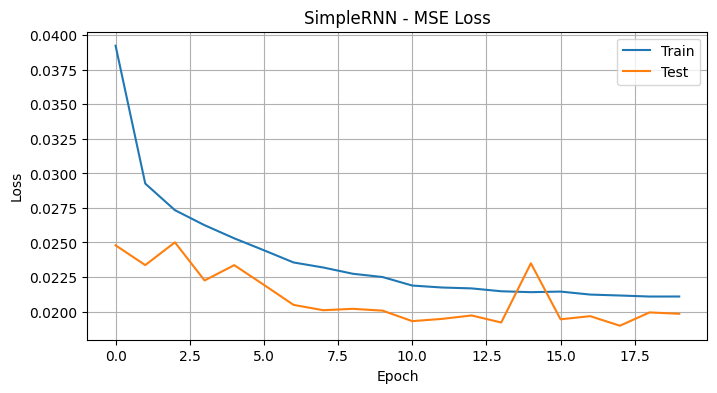


📦 Training LSTM...
Epoch 1: Train Loss = 0.0408, Test Loss = 0.0295
Epoch 2: Train Loss = 0.0287, Test Loss = 0.0236
Epoch 3: Train Loss = 0.0260, Test Loss = 0.0235
Epoch 4: Train Loss = 0.0244, Test Loss = 0.0217
Epoch 5: Train Loss = 0.0234, Test Loss = 0.0214
Epoch 6: Train Loss = 0.0227, Test Loss = 0.0204
Epoch 7: Train Loss = 0.0222, Test Loss = 0.0197
Epoch 8: Train Loss = 0.0219, Test Loss = 0.0201
Epoch 9: Train Loss = 0.0215, Test Loss = 0.0200
Epoch 10: Train Loss = 0.0212, Test Loss = 0.0201
Epoch 11: Train Loss = 0.0211, Test Loss = 0.0189
Epoch 12: Train Loss = 0.0209, Test Loss = 0.0197
Epoch 13: Train Loss = 0.0207, Test Loss = 0.0189
Epoch 14: Train Loss = 0.0206, Test Loss = 0.0186
Epoch 15: Train Loss = 0.0206, Test Loss = 0.0192
Epoch 16: Train Loss = 0.0204, Test Loss = 0.0192
Epoch 17: Train Loss = 0.0203, Test Loss = 0.0188
Epoch 18: Train Loss = 0.0203, Test Loss = 0.0184
Epoch 19: Train Loss = 0.0202, Test Loss = 0.0184
Epoch 20: Train Loss = 0.0201, Test Los

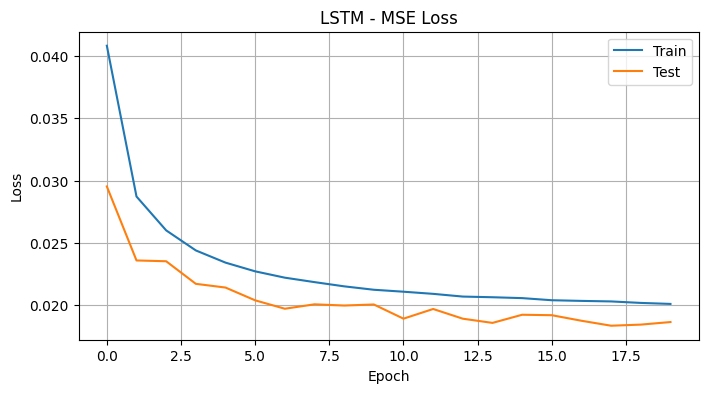


⚡ Training GRU...
Epoch 1: Train Loss = 0.0424, Test Loss = 0.0262
Epoch 2: Train Loss = 0.0280, Test Loss = 0.0227
Epoch 3: Train Loss = 0.0253, Test Loss = 0.0216
Epoch 4: Train Loss = 0.0241, Test Loss = 0.0223
Epoch 5: Train Loss = 0.0233, Test Loss = 0.0206
Epoch 6: Train Loss = 0.0226, Test Loss = 0.0198
Epoch 7: Train Loss = 0.0222, Test Loss = 0.0211
Epoch 8: Train Loss = 0.0220, Test Loss = 0.0193
Epoch 9: Train Loss = 0.0216, Test Loss = 0.0201
Epoch 10: Train Loss = 0.0214, Test Loss = 0.0196
Epoch 11: Train Loss = 0.0212, Test Loss = 0.0190
Epoch 12: Train Loss = 0.0212, Test Loss = 0.0193
Epoch 13: Train Loss = 0.0209, Test Loss = 0.0194
Epoch 14: Train Loss = 0.0209, Test Loss = 0.0192
Epoch 15: Train Loss = 0.0208, Test Loss = 0.0191
Epoch 16: Train Loss = 0.0205, Test Loss = 0.0192
Epoch 17: Train Loss = 0.0206, Test Loss = 0.0188
Epoch 18: Train Loss = 0.0205, Test Loss = 0.0191
Epoch 19: Train Loss = 0.0204, Test Loss = 0.0186
Epoch 20: Train Loss = 0.0203, Test Loss

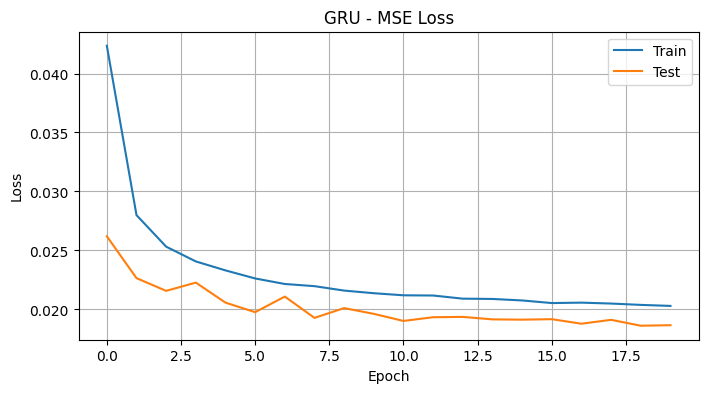


🌊 Training TCN...
Epoch 1: Train Loss = 0.0266, Test Loss = 0.0195
Epoch 2: Train Loss = 0.0210, Test Loss = 0.0197
Epoch 3: Train Loss = 0.0205, Test Loss = 0.0203
Epoch 4: Train Loss = 0.0201, Test Loss = 0.0181
Epoch 5: Train Loss = 0.0199, Test Loss = 0.0180
Epoch 6: Train Loss = 0.0197, Test Loss = 0.0186
Epoch 7: Train Loss = 0.0197, Test Loss = 0.0185
Epoch 8: Train Loss = 0.0197, Test Loss = 0.0180
Epoch 9: Train Loss = 0.0196, Test Loss = 0.0180
Epoch 10: Train Loss = 0.0194, Test Loss = 0.0184
Epoch 11: Train Loss = 0.0195, Test Loss = 0.0183
Epoch 12: Train Loss = 0.0193, Test Loss = 0.0181
Epoch 13: Train Loss = 0.0194, Test Loss = 0.0178
Epoch 14: Train Loss = 0.0193, Test Loss = 0.0177
Epoch 15: Train Loss = 0.0191, Test Loss = 0.0181
Epoch 16: Train Loss = 0.0191, Test Loss = 0.0185
Epoch 17: Train Loss = 0.0191, Test Loss = 0.0184
Epoch 18: Train Loss = 0.0191, Test Loss = 0.0180
Epoch 19: Train Loss = 0.0192, Test Loss = 0.0181
Epoch 20: Train Loss = 0.0190, Test Loss

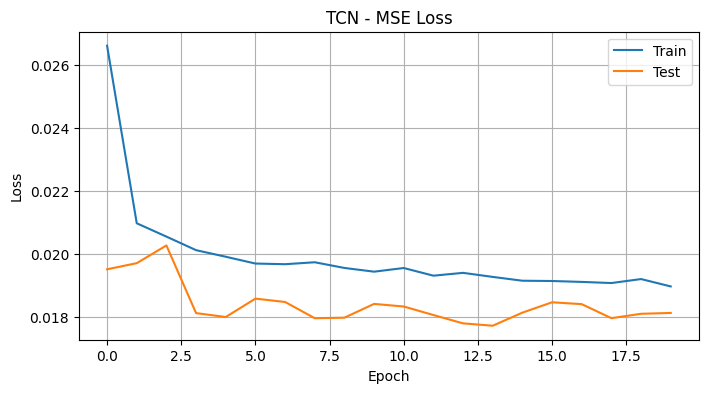


📊 Final Test MSEs:
SimpleRNN: 0.0198
LSTM: 0.0186
GRU: 0.0187
TCN: 0.0181


In [4]:
results = {}

# Train SimpleRNN
print("\n🔁 Training SimpleRNN...")
rnn_model = SimpleRNNModel(input_dim=input_dim, hidden_dim=hidden_dim)
rnn_train_losses, rnn_test_losses = train_model(rnn_model, train_loader, test_loader)
plot_losses(rnn_train_losses, rnn_test_losses, "SimpleRNN")
results['SimpleRNN'] = rnn_test_losses[-1]

# Train LSTM
print("\n📦 Training LSTM...")
lstm_model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim)
lstm_train_losses, lstm_test_losses = train_model(lstm_model, train_loader, test_loader)
plot_losses(lstm_train_losses, lstm_test_losses, "LSTM")
results['LSTM'] = lstm_test_losses[-1]

# Train GRU
print("\n⚡ Training GRU...")
gru_model = GRUModel(input_dim=input_dim, hidden_dim=hidden_dim)
gru_train_losses, gru_test_losses = train_model(gru_model, train_loader, test_loader)
plot_losses(gru_train_losses, gru_test_losses, "GRU")
results['GRU'] = gru_test_losses[-1]

# Train TCN
print("\n🌊 Training TCN...")
tcn_model = TCNModel(input_dim=input_dim, hidden_dim=hidden_dim)
tcn_train_losses, tcn_test_losses = train_model(tcn_model, train_loader, test_loader)
plot_losses(tcn_train_losses, tcn_test_losses, "TCN")
results['TCN'] = tcn_test_losses[-1]

# Final comparison
print("\n📊 Final Test MSEs:")
for model, loss in results.items():
    print(f"{model}: {loss:.4f}")


# Prediction Visualization

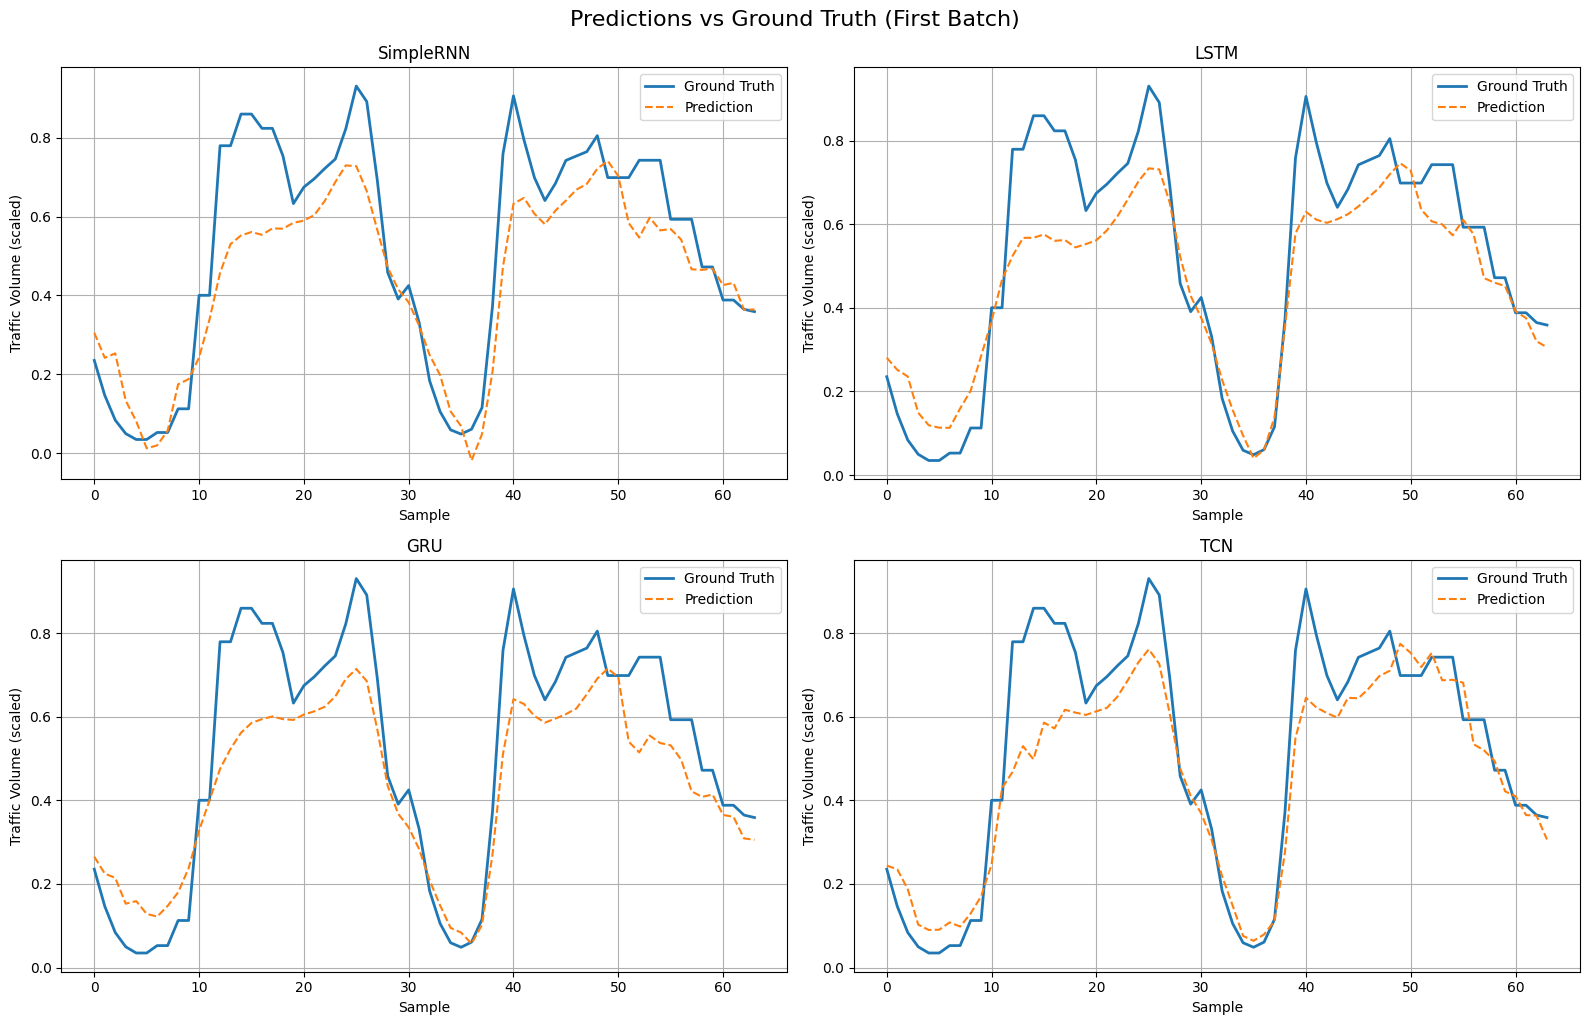

In [ ]:
def compare_predictions_subplots(models_dict, loader, num_batches=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    plt.figure(figsize=(16, 10))

    for i, (name, model) in enumerate(models_dict.items()):
        model.eval()
        model.to(device)
        preds, trues = [], []

        with torch.no_grad():
            for j, (X_batch, y_batch) in enumerate(loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch).cpu().numpy()
                preds.extend(y_pred)
                trues.extend(y_batch.cpu().numpy())
                if j >= num_batches - 1:
                    break

        plt.subplot(2, 2, i + 1)
        plt.plot(trues, label="Ground Truth", linewidth=2)
        plt.plot(preds, label="Prediction", linestyle="--")
        plt.title(name)
        plt.xlabel("Sample")
        plt.ylabel("Traffic Volume (scaled)")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.suptitle("Predictions vs Ground Truth (First Batch)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig("assets/prediction_subplots.png", dpi=300)
    plt.show()

all_models = {
    "SimpleRNN": rnn_model,
    "LSTM": lstm_model,
    "GRU": gru_model,
    "TCN": tcn_model
}

compare_predictions_subplots(all_models, test_loader, num_batches=1)


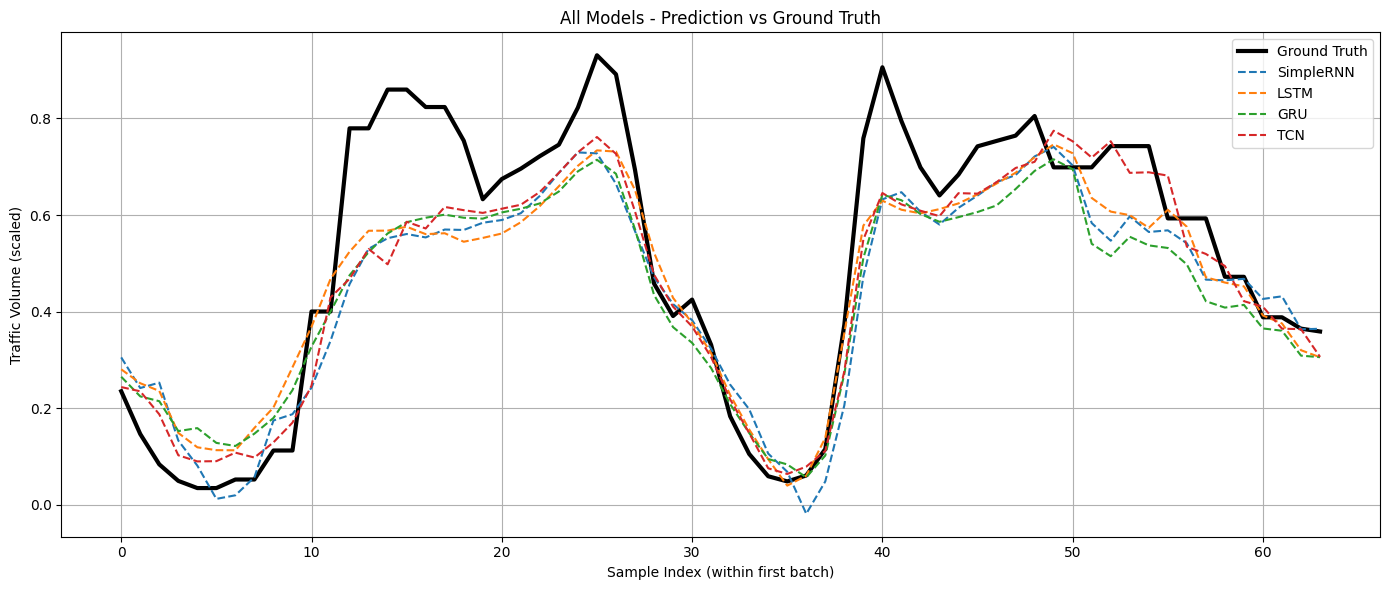

In [ ]:
def plot_combined_predictions(models_dict, loader, title="All Models - Prediction vs Ground Truth", num_batches=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = {}
    true_vals = []

    # Use same batch for all models
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        true_vals = y_batch.cpu().numpy()
        break  # just the first batch

    for name, model in models_dict.items():
        model.eval()
        model.to(device)
        with torch.no_grad():
            pred = model(X_batch).cpu().numpy()
        all_preds[name] = pred

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(true_vals, label="Ground Truth", linewidth=3, color='black')
    for name, preds in all_preds.items():
        plt.plot(preds, label=name, linestyle='--')
    plt.title(title)
    plt.xlabel("Sample Index (within first batch)")
    plt.ylabel("Traffic Volume (scaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.tight_layout()
    plt.savefig("assets/prediction_combined.png", dpi=300)
    plt.show()

plot_combined_predictions(all_models, test_loader)